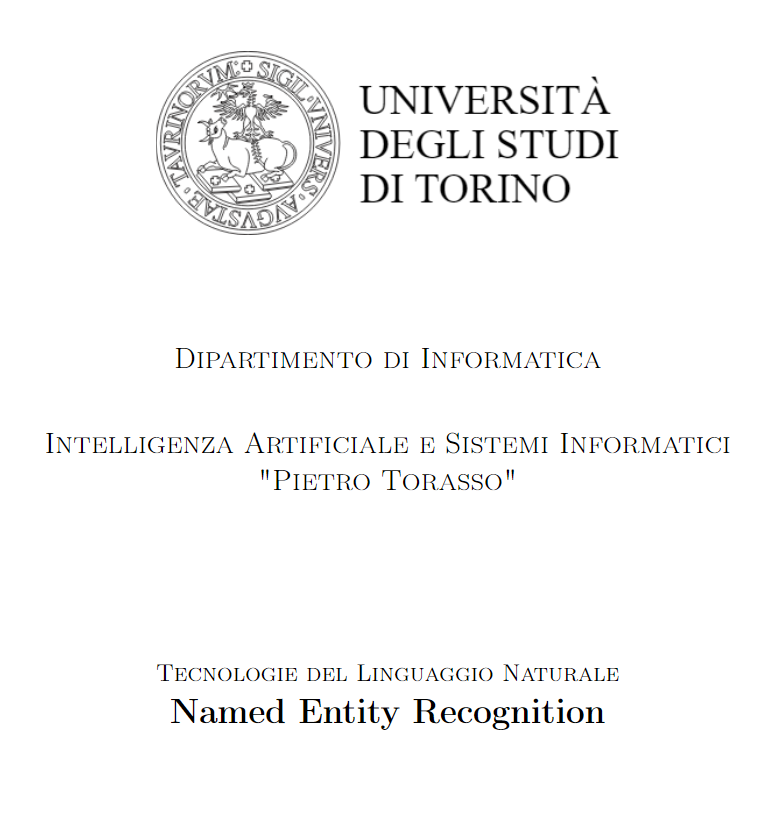

## <font color='darkred'>**UTILS**</font>


Inseriamo tutti i **package** di cui avremo bisogno 

In [ ]:
import csv
import math
import pprint 
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from pathlib import Path  
import matplotlib.pyplot as plt

!pip install nltk
pp = pprint.PrettyPrinter(indent=4)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

\\
Per prima cosa inseriamo uno snippet di codice di utilità per la stampa ordinata di dizionari che utilizzeremo in seguito


In [ ]:
"""
  Utility for printing a chunck of a dictionary, 
  whose entries values are > 15.
  ---------------------------------------------
  Args:
    - dictionary: the dictionary to be printed.
  Returns:
    - dictionary[elem] > 15
"""
def print_chunk_non_zero_dict(dictionary):
  for elem in dictionary:
    if dictionary[elem] > 100:
      print(elem, dictionary[elem])


## <font color='darkred'>**MODELING e LEARNING**</font>

Di seguito verranno eseguite le seguenti operazioni:


1. Lettura del **Dataset**,
2. Calcolo della probabilità di **Transizione**,
3. Calcolo della probabilità di **Emissione**,
4. Calcolo delle probabilità di Emissione per le **Parole Sconosciute**.





### <font color='red'>Lettura del Dataset</font>







Leggiamo i dataset di TRAINING e di VALIDAZIONE rispettivamente:

In [ ]:
''' Use 'pandas' built in read_csv() method to read both datasets '''

# TRAINING SET
data = pd.read_csv('./sample_data/train.conllu', sep = "\t", quoting =3 ,keep_default_na=False, names = ["word_nr","word","tag"])
# VALIDATION SET
data_validation = pd.read_csv('./sample_data/val.conllu', sep = "\t", quoting =3 ,keep_default_na=False, names = ["word_nr","word","tag"])

#print results
data.head(10)

,word_nr,word,tag
0,0,Nella,O
1,1,stagione,O
2,2,2003,O
3,3,-,O
4,4,2004,O
5,5,vince,O
6,6,un',O
7,7,altra,O
8,8,Supercoppa,B-MISC
9,9,italiana,I-MISC


### <font color='red'>Probabilità di Transizione</font>

Creiamo gli indici delle righe e i nomi delle colonne per la matrice
delle probabilità di transizione che verrà riempita in seguito.

In [ ]:
# COLUMNS names taken from the column `tag` of the dataframe `data`.
tags = data.tag.unique()
# ROWS indexes with the tag `START` added.
tags_with_start = np.insert(tags, 0, "START")
# COLUMNS indexes with the tag `START` added.
tags_with_end = np.insert(tags, len(tags), "END")

# DataFrame resulting from ROWS x COLUMNS filled zeros.
transition_prob = pd.DataFrame(0, index=tags_with_start, columns=tags_with_end).astype(float)

# Print results
print(transition_prob)

          O  B-MISC  I-MISC  B-LOC  I-LOC  B-ORG  B-PER  I-PER  I-ORG  END
START   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
O       0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
B-MISC  0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
I-MISC  0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
B-LOC   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
I-LOC   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
B-ORG   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
B-PER   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
I-PER   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0
I-ORG   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0


In [ ]:
''' 
Create a dict that will be used for counting 
occurrencies of tags in the dataset, in the form of:
----------------------------------------------------
  dict_single_tags = {
    START : 1
    O	: 0
    B-MISC : 0
    I-MISC : 0
    B-LOC : 0
    I-LOC	: 0
    B-ORG	: 0
    B-PER	: 0
    I-PER	: 0
    I-ORG : 0
    END : 1
  }
'''
dict_single_tags = {}
tags_with_start_end = np.insert(tags_with_start, len(tags_with_start), "END")
for tag in tags_with_start_end:
  if tag == "START" or tag == "END":
    dict_single_tags[tag] = 1
  else:
    dict_single_tags[tag] = 0


'''
List of tuples of consecutives tags in the form of:
---------------------------------------------------
  list_of_tuples = [
    (START, tag-1)
    (tag, tag+1),
    (tag+1, tag+2),
    (tag+2, tag+3),
    ...
  ]
'''
list_of_tuples = []
list_of_tuples.append(("START",data["tag"][0]))
for i in range(0, len(data["tag"])-1):
  #count number of occurrencies of the single tags
  dict_single_tags[data["tag"][i]] +=1
  if data["word_nr"][i+1] == 0:
    dict_single_tags["START"] +=1
    list_of_tuples.append(("START",data["tag"][i+1]))
    dict_single_tags["END"] +=1
    list_of_tuples.append((data["tag"][i], "END"))
    i += 1
  else:
    list_of_tuples.append((data["tag"][i] , data["tag"][i+1]))

'''
Cast the list_of_tuples to a set to obtain the uniques 
tuples and INITIALIZE the dict containing the occurrencies 
of the (tag, tag) tuples with zeros. Then COUNT and
update the dictionary.
'''

# INITIALIZE
set_of_tuples = set(list_of_tuples)
dict_of_tuples = {}
for couple in set_of_tuples:
  dict_of_tuples[couple] = 0
  
# COUNT
for tuple in list_of_tuples:
  dict_of_tuples[tuple] += 1


# Print results
print("DICT OF TUPLES")
pp.pprint(dict_of_tuples)

print("DICT SINGLE TAGS")
pp.pprint(dict_single_tags)


DICT OF TUPLES
{   ('B-LOC', 'B-LOC'): 214,
    ('B-LOC', 'B-PER'): 60,
    ('B-LOC', 'END'): 1,
    ('B-LOC', 'I-LOC'): 17063,
    ('B-LOC', 'I-PER'): 10,
    ('B-LOC', 'O'): 58587,
    ('B-MISC', 'B-MISC'): 282,
    ('B-MISC', 'B-PER'): 7,
    ('B-MISC', 'I-MISC'): 14481,
    ('B-MISC', 'I-PER'): 1,
    ('B-MISC', 'O'): 6784,
    ('B-ORG', 'B-LOC'): 5,
    ('B-ORG', 'B-MISC'): 7,
    ('B-ORG', 'B-ORG'): 8,
    ('B-ORG', 'B-PER'): 121,
    ('B-ORG', 'END'): 2,
    ('B-ORG', 'I-ORG'): 8304,
    ('B-ORG', 'I-PER'): 1,
    ('B-ORG', 'O'): 9131,
    ('B-PER', 'B-PER'): 38,
    ('B-PER', 'END'): 2,
    ('B-PER', 'I-PER'): 43272,
    ('B-PER', 'O'): 8842,
    ('I-LOC', 'B-LOC'): 13,
    ('I-LOC', 'B-ORG'): 1,
    ('I-LOC', 'B-PER'): 13,
    ('I-LOC', 'I-LOC'): 9491,
    ('I-LOC', 'I-PER'): 1,
    ('I-LOC', 'O'): 17036,
    ('I-MISC', 'B-MISC'): 41,
    ('I-MISC', 'B-PER'): 1,
    ('I-MISC', 'END'): 64,
    ('I-MISC', 'I-LOC'): 1,
    ('I-MISC', 'I-MISC'): 19146,
    ('I-MISC', 'I-PER'): 2,


Calcoliamo ed inseriamo i valori rappresentanti la **probabilità di transizione** all'interno del DataFrame seguendo la seguente formula.


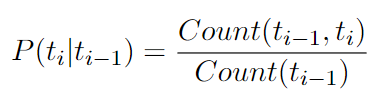


In [ ]:
'''
Fill the dataframe with the previous formula 
and the occurrencies calculated before.
'''
for tag_col in tags_with_start:
  for tag_row in tags_with_end: 
    if (tag_col, tag_row) in dict_of_tuples.keys():
      transition_prob[tag_row][tag_col] = dict_of_tuples[(tag_col, tag_row)] / dict_single_tags[tag_col]


# Print results.
transition_prob

,O,B-MISC,I-MISC,B-LOC,I-LOC,B-ORG,B-PER,I-PER,I-ORG,END
START,0.972534,0.001900,0.000000,0.004299,0.000000,0.001312,0.019955,0.000000,0.000000,0.000000
O,0.877826,0.010185,0.000173,0.036441,0.000000,0.008444,0.024241,0.000000,0.000000,0.042691
B-MISC,0.314730,0.013083,0.671816,0.000000,0.000000,0.000000,0.000325,0.000046,0.000000,0.000000
I-MISC,0.433410,0.001206,0.563383,0.000000,0.000029,0.000000,0.000029,0.000059,0.000000,0.001883
B-LOC,0.771541,0.000000,0.000000,0.002818,0.224705,0.000000,0.000790,0.000132,0.000000,0.000013
I-LOC,0.641536,0.000000,0.000000,0.000490,0.357409,0.000038,0.000490,0.000038,0.000000,0.000000
B-ORG,0.519427,0.000398,0.000000,0.000284,0.000000,0.000455,0.006883,0.000057,0.472382,0.000114
B-PER,0.169536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000729,0.829697,0.000000,0.000038
I-PER,0.872751,0.000061,0.000000,0.000000,0.000000,0.000000,0.000161,0.126906,0.000000,0.000121
I-ORG,0.655662,0.000160,0.000000,0.000000,0.000000,0.000000,0.002965,0.000080,0.334562,0.006571


In [ ]:
# Slice the Dataframe to obtain the t_probability of a word to be at the end of a sentence
end_transition_prob = transition_prob['END']
transition_prob = transition_prob.drop(['END'], axis=1)

end_transition_prob

START     0.000000
O         0.042691
B-MISC    0.000000
I-MISC    0.001883
B-LOC     0.000013
I-LOC     0.000000
B-ORG     0.000114
B-PER     0.000038
I-PER     0.000121
I-ORG     0.006571
Name: END, dtype: float64

### <font color='red'>Probabilità di Emissione</font>



In [ ]:
# Find how many different words we have in total.
unique_words = data["word"].astype(str).unique()


'''
Create a dictionary of the type 
-------------------------------
  dict = {
    (word,tag) : count
    (word,tag) : count
    (word,tag) : count
    (word,tag) : count    
  }
-------------------------------
This dict will contain all the possible
(word, tag) that appear inside the train
set with the respective count of how many
times they have appeared.
'''
tag_words_dict = {}
for u_word in unique_words:
  for u_tag in tags:
    tag_words_dict[(u_tag, u_word)] = 0



'''
Select the `word` and `tag` columns from the
starting pd.DataFrame, iterate through the df
row by row and for every (word, tag) row we
increase the occurrency count on the respective
entry of the dictionary by 1.
Resulting in the count of how many times a
(word, tag) has occurred.
'''
tag_words_df = data[["word", "tag"]]
for i in range(0,len(tag_words_df.word)):
  tag_words_dict[tag_words_df.tag[i], tag_words_df.word[i]] += 1



# Print Results.
print_chunk_non_zero_dict(tag_words_dict)

('O', 'Nella') 1186
('O', 'stagione') 2533
('O', '2003') 315
('O', '-') 6554
('I-MISC', '-') 574
('O', '2004') 381
('O', 'vince') 349
('O', "un'") 2391
('O', 'altra') 538
('O', 'italiana') 508
('O', 'a') 30067
('I-MISC', 'a') 173
('B-LOC', 'New') 756
('B-ORG', 'New') 256
('I-LOC', 'York') 595
('I-ORG', 'York') 155
('O', 'contro') 3023
('O', 'il') 38460
('I-PER', 'il') 106
('O', ',') 122540
('I-MISC', ',') 117
('O', 'ai') 3068
('O', 'nel') 12719
('O', 'primo') 2899
('O', 'tempo') 1286
('O', 'gol') 613
('O', "dell'") 8748
('O', '1') 1492
('O', 'che') 21671
('O', 'alla') 7506
('O', 'squadra') 1731
('O', 'la') 35234
('O', 'sconfitta') 522
('O', 'al') 11825
('O', '"') 46042
('O', '.') 87526
('O', 'Il') 11992
('B-MISC', 'Il') 366
('I-MISC', 'Il') 105
('O', 'non') 6137
('O', 'era') 4067
('O', 'ancora') 1123
('O', 'stato') 4726
('O', 'mentre') 1959
('O', 'i') 13282
('O', 'territori') 265
('O', 'del') 24887
('I-MISC', 'del') 503
('I-LOC', 'del') 1137
('O', 'e') 50625
('I-MISC', 'e') 171
('O', '

Come abbiamo fatto in precenza, calcoliamo ed inseriamo i valori rappresentanti la **probabilità di Emissione** all'interno del DataFrame seguendo la seguente formula.

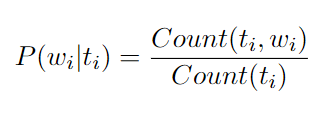

In [ ]:
'''
Create a pd.Dataframe that has the tags as the ROWS
indices and unique words as COLUMNS names. The
pd.Dataframe is initially filled with zeros.
'''
emission_prob = pd.DataFrame(index = tags,
                             columns = unique_words)

'''
From the dict we filled before named `tag_words_dict`
that contained the count of how many times a word is 
preceeded by a certain tag and the similar dict 
`dict_single_tags` with the count of single tags,
we fill the dataframe using the counting formula.
'''
keys = tag_words_dict.keys()
for tup in keys:
  # COUNT(T|W) / COUNT(T)
  emission_prob[tup[1]][tup[0]] = tag_words_dict[tup] / dict_single_tags[tup[0]] 



# Print results.
emission_prob

,Nella,stagione,2003,-,2004,vince,un',altra,Supercoppa,italiana,...,sila,Sersale,Petronà,indeboliranno,Professione,impenetrabilità,Identificazione,comportamentale,Vergemoli,Fabbriche
O,0.000574,0.001225,0.000152,0.003171,0.000184,0.000169,0.001157,0.00026,0.0,0.000246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-MISC,0.000139,0.0,0.000046,0.0,0.000278,0.0,0.0,0.0,0.002598,0.0,...,0.0,0.0,0.0,0.0,0.000046,0.0,0.000046,0.0,0.0,0.0
I-MISC,0.0,0.0,0.000294,0.01689,0.000412,0.0,0.000059,0.000118,0.0,0.000942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-LOC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000013,0.000013,0.0,0.0,0.0,0.0,0.0,0.000013,0.000013
I-LOC,0.0,0.0,0.0,0.000264,0.0,0.0,0.0,0.0,0.0,0.000038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000038,0.0
B-ORG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-PER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-PER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-ORG,0.0,0.0,0.0,0.00008,0.0,0.0,0.0,0.0,0.0,0.00016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### <font color='red'>Probabilità di Emissione per parole UNKNOWN</font>

Di seguito calcoleremo la probabilità di emissione per la parole che non compaiono mai nel training set.

Questa probabilità verrà utilizzata nella tecnica di smoothing `unknown_once`.

Questo viene fatto in 3 step:


1.   *Ricercare le parole che compaiono solo una volta all'interno del validation set,*
2.   *Per ogni tag, contare quante volte una parola appare associata a tale tag,*
3.   *Calcolo della probabilità come:* **Count(Tag) / Count(Parole_sconosciute)**



In [ ]:
'''
Count the occurrencies of every word in the validation
set and store this count in `value_counts` then filters
leaving only the words with count == 1. Cast the
pd.Series containing words to the list `once_words_list` .
'''
value_counts = data_validation['word'].value_counts()
value_counts = value_counts[value_counts==1]
once_words_list = value_counts.index.to_list()


'''
Create a dictionary containing the count, for every tag,
of how many times a word that occurs only one time is 
associated with a specific tag. 
-----------------------------
  tag_onceword_count_dict = {
    (tag) : count
    (tag) : count
    (tag) : count
    (tag) : count    
  }
-----------------------------
Initially the dict is filled with zeros.
'''
tag_onceword_count_dict = {}
for tag in tags:
  tag_onceword_count_dict[tag] = 0


'''
Fill the dictionary by counting for each tag the amount 
of occurrencies. Then replace the dict values, for every
entry with the actual probabilities.
'''
for i in range(0, len(data_validation["word"])-1):
  if data_validation.iloc[i,1] in once_words_list:
    tag_onceword_count_dict[data_validation.iloc[i,2]] += 1
for elem in tag_onceword_count_dict:
  tag_onceword_count_dict[elem] = tag_onceword_count_dict[elem] / len(once_words_list)


'''
Create a new dictionary that is a plain copy of 
the resulting dict of the previous calculations.
`unkown_word` contains the distribution of p
of having a specific tag associated for every 
word that appears only 1 time. 
'''
unknown_word = tag_onceword_count_dict

## <font color='darkred'>**DECODING**</font>
Di seguito verranno eseguite le seguenti operazioni:


1. Inserimento di due **Metodi Ausiliari** per il calcolo delle probabilità delle parole sconosciute,
2. Implementazione dell' algoritmo di **Viterbi**,
3. Esecuzione dell' algoritmo e **Test** su frasi con display dei risultati.




### <font color='red'>Metodi Ausiliari</font>

In [ ]:
'''
Retrieve the emission probability of the first
word, given that has never been seen in the train
set. The smoothing type can be one of: 
'other' which assign a tag 'O' to an unknown
word, 'uniform' which distributes the prob
equally to all possible tags and 'once' which
distributes the probability on the same prob
of the word that appears only once in the train
set.                 
---------------------------------------------
Args:
  - word: the input word.
  - state_graph: list of possible tags.
  - smoothing_type: possible smoothings types
                    
Returns:
  - pd.Series : the probability distribution
                of the input word to be associated 
                with a tag in state_graph.
---------------------------------------------
'''
def first_word_unknown_proba(word, state_graph, smoothing_type):
  if (smoothing_type == "unknown_misc"):
    return pd.Series(data = [0,1.0,0,0,0,0,0,0,0], index=state_graph, name=word, dtype ="float64")
  elif (smoothing_type == "unknown_misc_pers"):
    return pd.Series(data = [0,0.5,0,0,0,0,0.5,0,0], index=state_graph, name=word, dtype ="float64")
  elif (smoothing_type == "unknown_uniform"):
    return pd.Series(data = [1/len(state_graph)]*9, index=state_graph, name=word, dtype ="float64")
  elif (smoothing_type == "unknown_once"):
    return pd.Series(data = unknown_word.values(), index=state_graph, name=word, dtype ="float64")


'''
Similar to the previous function but 
generalized for a word inside the sentence.
-------------------------------------------
Args:
  - word: the input word.
  - state: the index of the current tag.
  - state_graph: list of possible tags.
  - smoothing_type: possible smoothings types.
  - inside_entity: boolean signaling that we are already inside of a "chunk" of an entity
Returns:
  - pd.Series : the probability of the input
                word to be associated with a
                tag in state_graph.
--------------------------------------------
'''
def word_unknown_proba(word, state, state_graph, smoothing_type, inside_entity):
  if (smoothing_type == "unknown_misc"):
    if (inside_entity == True):
      if (state_graph[state] == "I-MISC"):
        return 1.0
      else:
        return 0.0
    else:
      if (state_graph[state] == "B-MISC"):
        return 1.0
      else:
        return 0.0
  elif (smoothing_type == "unknown_misc_pers"):
    if (inside_entity == True):
      if (state_graph[state] == "I-MISC") or (state_graph[state] == "I-PER"):
        return 0.5
      else:
        return 0.0
    else:
      if (state_graph[state] == "B-MISC") or (state_graph[state] == "B-PER"):
        return 0.5
      else:
        return 0.0
  elif (smoothing_type == "unknown_uniform"):
    return 1/len(state_graph)
  elif (smoothing_type == "unknown_once"):
    return unknown_word[state_graph[state]]

### <font color='red'>Algoritmo di Viterbi</font>


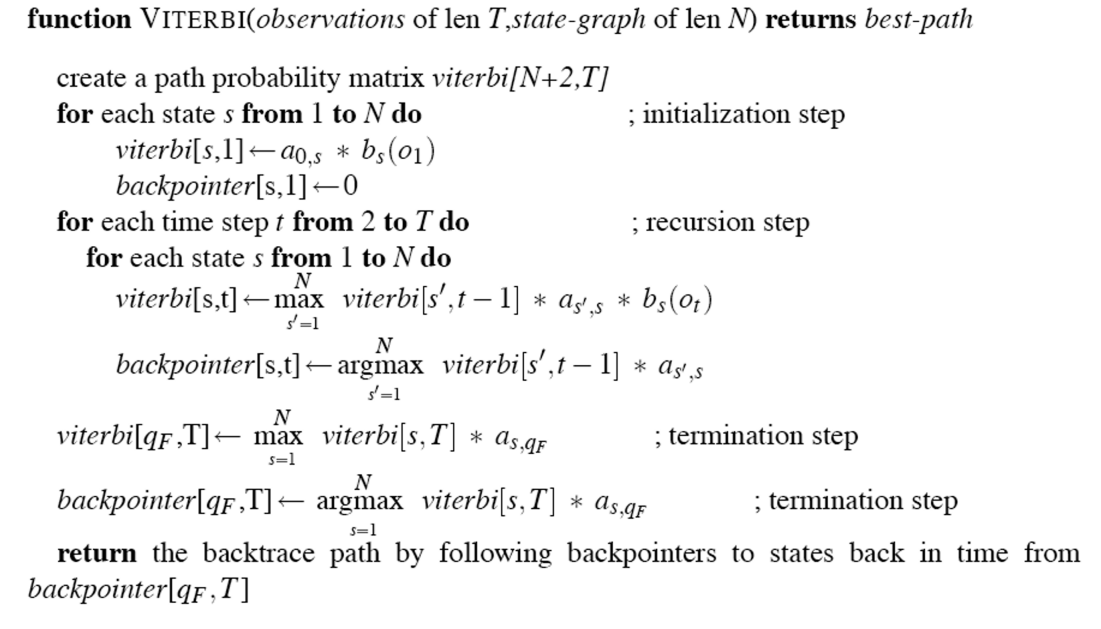




In [ ]:
'''
Implementation of the Viterbi algorithm, as seen 
in the lessons of TLN AA 2021/2022.
------------------------------------------------
Args:
  - obs_tokens: the input tokenized sentence.
  - state_graph: the list of the possible tokens.
  - smoothing_type: possible smoothings types.
Returns: 
  - result_series: pd.Series containing tag 
                    associated to the input
                    sentence.
------------------------------------------------
'''
def viterbi_algorithm (obs_tokens, state_graph, smoothing_type):
  
  '''
  INITIALIZATION STEP
  -------------------
  Find the first column of the viterbi matrix
  'column_one' = 'transition_one' * 'emission_one'.
  Then we initialize the result matrix 'viterbi_matrix'
  and the backpointer matrix 'bp_matrix'  
  '''

  # TRANSITION PROBABILITY
  transition_one = transition_prob.loc["START"]

  # Boolean used to follow up Begins-tags of unknown entities with Inside-tags of the same entity
  inside_unknown_entity = False

  # EMISSION PROBABILITY of:
  # - known word
  if obs_tokens[0] in emission_prob.columns:
    emission_one = emission_prob[obs_tokens[0]]
  # - unknown word
  else:
    emission_one = first_word_unknown_proba(obs_tokens[0], state_graph, smoothing_type)
    inside_unknown_entity = True

  # TRANSITION * EMISSION
  column_one = transition_one*emission_one

  # Data structures initialization.
  viterbi_matrix = pd.DataFrame(data=column_one, columns=[obs_tokens[0]], dtype ="float64")
  bp_matrix = pd.DataFrame(data=["START" for elem in state_graph], index=state_graph, columns=[obs_tokens[0]])

  '''
  RECURSION STEP
  --------------
  The core of the Viterbi Algorithm implementation,
  with 2 indeces 't' and 's' iterating through the 
  words of the sentence and the possible tags 
  respectively. 
  The outer loop creates 2 pd.Series for storing
  the current word probability for each tag, and
  the current index of the max prob for later use
  in backtracking. Then the Series are added to
  the DataFrame.
  '''
  for t in range(0, len(obs_tokens)-1):
    current = pd.Series(data=None, index=state_graph, name=obs_tokens[t+1], dtype ="float64")
    bp_current = pd.Series(data=None, index=state_graph, name=obs_tokens[t+1], dtype ="string")

    if (obs_tokens[t+1] in emission_prob.columns):
      known_word = True
    else:
      known_word = False

    for s in range(0,len(state_graph)):
      transition_col = transition_prob.iloc[1:,s]

      # known word
      if (known_word):
        emission_cell = emission_prob.loc[state_graph[s],obs_tokens[t+1]]
        
      # unknown word
      else:
        emission_cell = word_unknown_proba(obs_tokens[t+1], s, state_graph, smoothing_type, inside_unknown_entity)

      # Series
      viterbi_prob = viterbi_matrix[obs_tokens[t]]*transition_col*emission_cell
      current[s] = viterbi_prob.max()
      bp_current[s] = viterbi_prob.idxmax()

    if (known_word):
      inside_unknown_entity = False
    elif (not known_word and (not inside_unknown_entity) ):
      inside_unknown_entity = True

    

    # Add the Series to the relatives pd.Dataframe
    viterbi_matrix[obs_tokens[t+1]] = current
    bp_matrix[obs_tokens[t+1]] = bp_current

  '''
  TERMINATION STEP
  ----------------
  In this step we calculate the probability of transitioning from
  the tags contained in the last viterbi column to an imaginary "END" tag.
  To do this we consider the very last column (the one associated with
  the very last word of the sentence) and multiply each row for the 
  transition probability of its tag towards the "END" tag.
  Emission probability is not taken into account, given that the "END" tag
  is not emitting any word.
  '''
  for s in state_graph:
    viterbi_matrix.loc[s,obs_tokens[len(obs_tokens)-1]] = viterbi_matrix.loc[s,obs_tokens[len(obs_tokens)-1]] * end_transition_prob[s]

  '''
  BACKTRACKING
  ----------------
  In this step we create the final best path starting
  by inserting in the head of the result list, iterating
  from the end to the start of the bp structure, the 
  previous node with the highest probability. 
  '''

  # Get best last index and insert in result list.
  end_bp_index = viterbi_matrix.iloc[:,[-1]].idxmax().tolist()[0]
  result_list= []
  result_list.insert(0,end_bp_index)

  # Fill the result list with the best node for each step.
  for i in range(len(obs_tokens)-1,0,-1):
    result_list.insert(0, bp_matrix.at[result_list[0],obs_tokens[i]])

  # Return the result as a pd.Series for better visualization.
  result_series = pd.Series(data=result_list, index=obs_tokens, name="TAG")
  return result_series;

### <font color='red'>Test e risultati</font>

In [ ]:
'''
Test the Viterbi implementation with the 3 sentences
given during the TLN lessons, as a generic baseline.
The algorithm is run three times, once per smoothing
type:
- unknown_misc
- unknown_misc_pers
- unknown_uniform
- unknown_once
'''

sentence_1 = word_tokenize("La vera casa di Harry Potter è il castello di Hogwards.")
sentence_2 = word_tokenize("Harry le raccontò del loro incontro a Diagon Alley.")
sentence_3= word_tokenize("Mr. Dursley era direttore di una ditta di nome Grunnings, che faceva trapani.")

# Print Results
print("unknown MISC")
print(viterbi_algorithm(sentence_1, tags, "unknown_misc"))
print("\nunknown MISC-PERS")
print(viterbi_algorithm(sentence_1, tags, "unknown_misc_pers"))
print("\nunkown UNIFORM")
print(viterbi_algorithm(sentence_1, tags, "unknown_uniform"))
print("\nunknown ONCE")
print(viterbi_algorithm(sentence_1, tags, "unknown_once"))
print("\n")
print("unknown MISC")
print(viterbi_algorithm(sentence_2, tags, "unknown_misc"))
print("\nunknown MISC-PERS")
print(viterbi_algorithm(sentence_2, tags, "unknown_misc_pers"))
print("\nunkown UNIFORM")
print(viterbi_algorithm(sentence_2, tags, "unknown_uniform"))
print("\nunknown ONCE")
print(viterbi_algorithm(sentence_2, tags, "unknown_once"))
print("\n")
print("unknown MISC")
print(viterbi_algorithm(sentence_3, tags, "unknown_misc"))
print("\nunknown MISC-PERS")
print(viterbi_algorithm(sentence_3, tags, "unknown_misc_pers"))
print("\nunkown UNIFORM")
print(viterbi_algorithm(sentence_3, tags, "unknown_uniform"))
print("\nunknown ONCE")
print(viterbi_algorithm(sentence_3, tags, "unknown_once"))

unknown MISC
La               O
vera             O
casa             O
di               O
Harry       B-MISC
Potter      I-MISC
è                O
il               O
castello         O
di               O
Hogwards    B-MISC
.                O
Name: TAG, dtype: object

unknown MISC-PERS
La               O
vera             O
casa             O
di               O
Harry       B-MISC
Potter      I-MISC
è                O
il               O
castello         O
di               O
Hogwards     B-PER
.                O
Name: TAG, dtype: object

unkown UNIFORM
La               O
vera             O
casa             O
di               O
Harry       B-MISC
Potter      I-MISC
è                O
il               O
castello         O
di               O
Hogwards         O
.                O
Name: TAG, dtype: object

unknown ONCE
La               O
vera             O
casa             O
di               O
Harry       B-MISC
Potter      I-MISC
è                O
il               O
castello         O
di      

## <font color='darkred'>**EVALUATION**</font>



### <font color='red'>Lettura e Parsing del Test Set</font>
La lettura e la formattazione dei dataset, come in precedenza, viene effettuata attraverso la libreria Pandas. I DataFrame risultanti si presentano nella forma:

word_nr  | word | tag
--- | --------  | ----
$i$   | $word_{i}$  | $tag$
$i+1$ | $word_{i+1}$  | $tag$

In [ ]:
# Read the test with pandas
data_test = pd.read_csv('./sample_data/test.conllu', sep = "\t", quoting =3 ,keep_default_na=False, names = ["word_nr","word","tag"])

In [ ]:
# Parse the data_test in order to obtain a list of sentences
# Idea:
# whenever we encounter 'word_nr == 0' that means we have found a new sentence

j=0
sentences = []

for i in range(1, len(data_test["word"])):
  if data_test['word_nr'][i] == 0:
    sentences.append(data_test.iloc[j:i,:])
    j=i
  #count the last sentence when we reach the end of the data_test
  elif i == (len(data_test["word"])-1):
    sentences.append(data_test.iloc[j:i+1,:])

print(sentences[0])

    word_nr          word    tag
0         0            Si      O
1         1       stabilì      O
2         2            ad      O
3         3       Amburgo  B-LOC
4         4           per      O
5         5            la      O
6         6           sua      O
7         7   ammirazione      O
8         8           nei      O
9         9     confronti      O
10       10         della      O
11       11   letteratura      O
12       12       tedesca      O
13       13             (      O
14       14         aveva      O
15       15      imparato      O
16       16            la      O
17       17        lingua      O
18       18            in      O
19       19       carcere      O
20       20             )      O
21       21             ,      O
22       22  specialmente      O
23       23           per      O
24       24             i      O
25       25     romantici      O
26       26          come      O
27       27       Novalis  B-PER
28       28             e      O
29       2

### <font color='red'>Applicazione dell'algoritmo di Viterbi sulle frasi del test set e salvataggio dei risultati</font>

In [ ]:
# Run Viterbi on all the sentences contained in the test set and save the results
# We run it once for each smoothing technique

results_unknown_misc = []
results_unknown_misc_pers = []
results_unknown_uniform = []
results_unknown_once = []

for i in range(int(len(sentences))):
  results_unknown_misc.append(viterbi_algorithm(sentences[i]['word'].to_list(), tags, "unknown_misc"))

for i in range(int(len(sentences))):
  results_unknown_misc_pers.append(viterbi_algorithm(sentences[i]['word'].to_list(), tags, "unknown_misc_pers"))

for i in range(int(len(sentences))):
  results_unknown_uniform.append(viterbi_algorithm(sentences[i]['word'].to_list(), tags, "unknown_uniform"))

for i in range(int(len(sentences))):
  results_unknown_once.append(viterbi_algorithm(sentences[i]['word'].to_list(), tags, "unknown_once"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
# Save the Viterbi results as .csv files for later use (so that we avoid re-running Viterbi)

filepath = Path('sample_data/out1.csv')
pd.concat(results_unknown_other).to_csv(filepath)

filepath = Path('sample_data/out2.csv')
pd.concat(results_unknown_uniform).to_csv(filepath)

filepath = Path('sample_data/out3.csv')
pd.concat(results_unknown_once).to_csv(filepath)

In [ ]:
# Import the Viterbi results that we previously saved as .csv

viterbi_out1 = pd.read_csv('./sample_data/out1.csv', names = ["word","tag"])
viterbi_out2 = pd.read_csv('./sample_data/out2.csv', names = ["word","tag"])
viterbi_out3 = pd.read_csv('./sample_data/out3.csv', names = ["word","tag"])

# Importing the Viterbi outputs causes the first row to be (NaN, TAG), which is not ideal, so we drop it for all 3 files.

viterbi_out1 = viterbi_out1.drop(viterbi_out1.index[0])
viterbi_out2 = viterbi_out2.drop(viterbi_out2.index[0])
viterbi_out3 = viterbi_out3.drop(viterbi_out3.index[0])

print(viterbi_out1.head(20))

           word tag
1            Si   O
2       stabilì   O
3            ad   O
4       Amburgo   O
5           per   O
6            la   O
7           sua   O
8   ammirazione   O
9           nei   O
10    confronti   O
11        della   O
12  letteratura   O
13      tedesca   O
14            (   O
15        aveva   O
16     imparato   O
17           la   O
18       lingua   O
19           in   O
20      carcere   O


### <font color='red'>Calcolo delle performance sui risultati ottenuti</font>

In [ ]:
'''
Evaluate the number of correct/incorrect NER classifications.
--------
Args:
- test set
- Viterbi output
--------
Returns:
- tp: number of true positives
- fp: number of false positives
- tn: number of truee negatives
- fn: number of false negatives
- error_matrix: Dataframe matrix containing for all the misclassified tokens (words) respectively the correct tag and the predicted tag.
  Structure of error_matrix:

            Amburgo	    e	    Hölderlin	 ...
corretto      B-LOC	  I-ORG 	  B-PER    ...
assegnato 	   O	      O	      I-PER    ...

'''

def eval(test_set, output):
  tp = 0; fp = 0; tn = 0; fn = 0
  error_matrix = pd.DataFrame(index=["corretto", "assegnato"])

  for i in range (len(test_set["word"])):
    # true positive
    if (test_set.iloc[i,2] != "O" and test_set.iloc[i,2] == output.iloc[i,1]):
      tp += 1
    # false positive
    elif (output.iloc[i,1] != "O" and test_set.iloc[i,2] != output.iloc[i,1]):
      col = [test_set.iloc[i,2],output.iloc[i,1]]
      current = pd.Series(data=col, index=["corretto", "assegnato"], name=output.iloc[i,0])
      error_matrix[output.iloc[i,0]] = current
      fp += 1
    # true negative
    elif (test_set.iloc[i,2] == "O" and test_set.iloc[i,2] == output.iloc[i,1]):
      tn += 1
    # false negative
    elif (output.iloc[i,1] == "O" and test_set.iloc[i,2] != output.iloc[i,1]):
      col = [test_set.iloc[i,2],output.iloc[i,1]]
      current = pd.Series(data=col, index=["corretto", "assegnato"], name=output.iloc[i,0])
      error_matrix[output.iloc[i,0]] = current
      fn += 1
  return tp, fp, tn, fn, error_matrix

'''
Evaluates and returns measurement metrics.
---------
Args:
- tp: number of true positives
- fp: number of false positives
- tn: number of truee negatives
- fn: number of false negatives
- n_words: total count of words
---------
Returns:
- accuracy
- precision
- recall
- f
'''
def calculate_metrics(tp, fp, tn, fn, n_words):
  accuracy = (tp+tn) / n_words
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f = 2*((precision*recall)/(precision+recall))

  return accuracy, precision, recall, f

'''
Auxiliary function for displaying the final results.
'''

def print_metrics(accuracy, precision, recall, f):
  print("ACCURACY: " + str(accuracy))
  print("\nPRECISION: " + str(precision))
  print("\nRECALL: " + str(recall))
  print("\nF: " + str(f))
  print("\n \n")

In [ ]:
#Calculate metrics for the 3 different smoothing types

# unknown_other
tp, fp, tn, fn, error_matrix = eval(data_test, viterbi_out1)
accuracy, precision, recall, f = calculate_metrics(tp, fp, tn, fn, len(viterbi_out1['word']))
print_metrics(accuracy, precision, recall, f)

# unknown_uniform
tp, fp, tn, fn, error_matrix2 = eval(data_test, viterbi_out2)
accuracy2, precision2, recall2, f2 = calculate_metrics(tp, fp, tn, fn, len(viterbi_out2['word']))
print_metrics(accuracy2, precision2, recall2, f2)

# unknown_once
tp, fp, tn, fn, error_matrix3 = eval(data_test, viterbi_out3)
accuracy3, precision3, recall3, f3 = calculate_metrics(tp, fp, tn, fn, len(viterbi_out3['word']))
print_metrics(accuracy3, precision3, recall3, f3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


ACCURACY: 0.9457302932927881

PRECISION: 0.7904412967385259

RECALL: 0.6953981638702622

F: 0.7398799681548165

 

ACCURACY: 0.948774379843228

PRECISION: 0.7881376919266964

RECALL: 0.7347127232851413

F: 0.7604880744358319

 

ACCURACY: 0.9464841279474615

PRECISION: 0.7890617450961446

RECALL: 0.7059332046220788

F: 0.7451863117870722

 



In [ ]:
# Returns a Dataframe displaying how many times each tag has been misclassified, given the error_matrix of a NER tagging
def count_error(error_matrix):
  error_count = pd.DataFrame(data = 0, index = ["count"], columns = tags, dtype = "int")

  for word in error_matrix:
    error_count.loc["count",error_matrix[word]["corretto"]] += 1

  return error_count

In [ ]:
# Display the count of misclassified tags for all smoothing types

out1_errors = count_error(error_matrix)
out2_errors = count_error(error_matrix2)
out3_errors = count_error(error_matrix3)

print(out1_errors)
print("\n")
print(out2_errors)
print("\n")
print(out3_errors)

          O  B-MISC  I-MISC  B-LOC  I-LOC  B-ORG  B-PER  I-PER  I-ORG
count  1753     623     804   1851    572    411   1458   1867    248


          O  B-MISC  I-MISC  B-LOC  I-LOC  B-ORG  B-PER  I-PER  I-ORG
count  1904     607     757   1843    563    400   1351   1141    229


          O  B-MISC  I-MISC  B-LOC  I-LOC  B-ORG  B-PER  I-PER  I-ORG
count  1794     611     790   1844    566    402   1388   1812    232


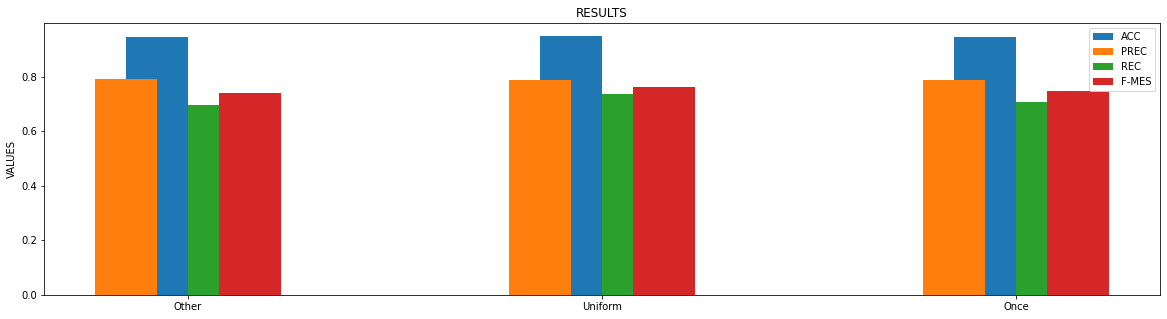

In [ ]:

# Plot the metrics

labels = ['Other','Uniform', 'Once']
accuracy_means = [accuracy,  accuracy2, accuracy3]
precision_means = [precision, precision2, precision3]
recall_means = [recall, recall2, recall3]
F_measure = [f, f2, f3]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_means, width, label='ACC')
rects2 = ax.bar(x - 2*width/2, precision_means, width, label='PREC')
rects2 = ax.bar(x + width/2, recall_means, width, label='REC')
rects2 = ax.bar(x + 2*width/2, F_measure, width, label='F-MES')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('VALUES')
ax.set_title('RESULTS')

ax.set_xticks(x) # values
ax.set_xticklabels(labels) # labels

ax.legend()

plt.rcParams["figure.figsize"] = (20,5)
plt.show()

### <font color='red'>Implementazione di una Baseline "facile"</font>

In [ ]:
# Baseline algorithm for NER tagging
# 
# Assigns the most frequent TAG to each word
# MISC is assigned to unknown words
def baseline_easy (obs_tokens, state_graph):

  result_list = []
  inside_unknown_entity = False
  
  for word in obs_tokens:
    if word in emission_prob.columns:
      result_list.append(emission_prob[word].astype("float64").idxmax())
      inside_unknown_entity = False
    else:
      if (inside_unknown_entity):
        result_list.append("I-MISC")
      else:
        result_list.append("B-MISC")
        inside_unknown_entity = True

  result_series = pd.Series(data=result_list, index=obs_tokens, name="TAG")

  return result_series;

In [ ]:
# Run the Baseline algorithm on the test dataset sentences

results_baseline_easy = []

for sentence in sentences:
  results_baseline_easy.append(baseline_easy(sentence['word'].to_list(), tags))

In [ ]:
# Save results for later use

filepath = Path('sample_data/out_base.csv')  
pd.concat(results_baseline_easy).to_csv(filepath)

In [ ]:
# Read results previously saved

base_out1 = pd.read_csv('./sample_data/out_base.csv', names = ["word","tag"])

#First row (NaN, TAG) not needed, so we drop it
base_out1 = base_out1.drop(base_out1.index[0])

### <font color='red'>Calcolo performance della Baseline"</font>

In [ ]:
#Calculate metrics and errors for the Baseline

tp_b, fp_b, tn_b, fn_b, error_matrix_b = eval(data_test, base_out1)
accuracy_b, precision_b, recall_b, f_b = calculate_metrics(tp_b, fp_b, tn_b, fn_b, len(base_out1['word']))
out_b_errors = count_error(error_matrix_b)

print_metrics(accuracy_b, precision_b, recall_b, f_b)

print(out_b_errors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


ACCURACY: 0.8336133594833038

PRECISION: 0.3357684052649272

RECALL: 0.9731319793149966

F: 0.49926942746183717

 

          O  B-MISC  I-MISC  B-LOC  I-LOC  B-ORG  B-PER  I-PER  I-ORG
count  6769     262     759   1573    521    329   1060   1582    159


### <font color='red'>Preparazione dei dati da fornire in input alla MEMM Baseline"</font>

In [ ]:

# Preparing the training data for MEMM

memm_word = data['word'].values
memm_tag = data['tag'].values

textfile = open("sample_data/memm_train.txt", "w")
for i in range(len(memm_word)):
    textfile.write(memm_word[i] + "\t" + memm_tag[i] + "\n")
textfile.close()


In [ ]:
# Preparing the test data for MEMM

memm_word = data_test['word'].values
memm_tag = data_test['tag'].values

textfile = open("sample_data/memm_test.txt", "w")
for i in range(len(memm_word)):
    textfile.write(memm_word[i] + "\t" + memm_tag[i] + "\n")
textfile.close()